In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv
import pandas as pd
import scipy.optimize as sp

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

%run ../aux_funcs.py
%run ../RSRG_bdry_class.py
%run ../bdry_aux_funcs.py

In [2]:
log_file = pd.read_csv("bdry_log_file.csv")
ts_list = log_file['ts'].tolist()
log_file

,L,steps,w_blk,w_bdry,w_mixed,n_runs,ts
0,30,892,2.6,2.6,2.6,30,1678748898
1,30,892,2.2,2.6,2.6,30,1678749434
2,30,892,2.4,2.6,2.6,30,1678749560
3,30,892,2.8,2.6,2.6,30,1678749688
4,30,892,3.0,2.6,2.6,30,1678749823
5,30,892,3.2,2.6,2.6,30,1678749956
6,30,892,1.7,2.6,2.6,30,1678750768
7,30,892,1.3,2.6,2.6,30,1678750892
8,30,892,0.8,2.6,2.6,30,1678751019
9,30,892,2.0,2.6,2.6,30,1678751143


In [3]:
ts = str(ts_list[-1])

with open("IsingB_2D_output_"+ts+".pkl", "rb") as fp:   # Unpickling
    output_data = pickle.load(fp)

with open("IsingB_2D_input_"+ts+".pkl", "rb") as fp:   
    input_dict = pickle.load(fp)
    
Omegas = np.array([])
dec_types = np.array([])
h_array_blk, h_array_bdry = [], []


for core, item in enumerate(output_data):
    h_dist_list_blk, h_dist_list_bdry, Omega_list_composite, decimation_type_composite = item
    Omegas = np.concatenate((Omegas, Omega_list_composite))
    dec_types = np.concatenate((dec_types, decimation_type_composite))
    if core==0:
        h_array_blk = h_dist_list_blk
        h_array_bdry = h_dist_list_bdry

    else:
        for i in range(len(input_dict['measure_list'])):
            h_array_blk[i] = np.concatenate((h_array_blk[i], h_dist_list_blk[i]))
            h_array_bdry[i] = np.concatenate((h_array_bdry[i], h_dist_list_bdry[i]))
        
        
with open("IsingB_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)
    
print(input_dict)


{'L': 70, 'steps': 4860, 'measure_list': array([4900, 3809, 2961, 2302, 1789, 1391, 1081,  841,  653,  508,  395,
        307,  238,  185,  144,  112,   87,   67,   52,   41]), 'w_blk': 1.7999999999999998, 'w_bdry': 0.1, 'w_mixed': 2.6, 'n_runs': 60}


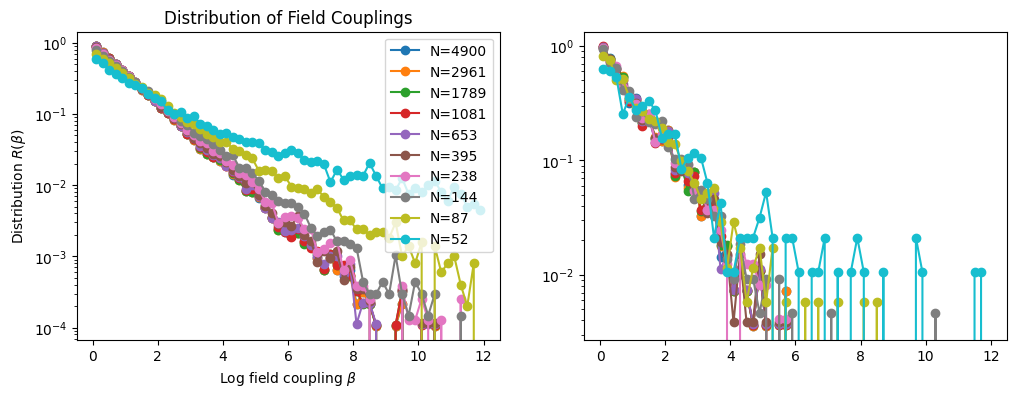

In [4]:
measure_list = input_dict['measure_list']
n_runs = input_dict['n_runs']
n_bins_h = 60
width_blk_list = []
width_bdry_list = []
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i,step in enumerate(measure_list[:-1]): 
    n_blk,bins_blk = np.histogram(h_dist_list_blk[i], density=True, bins = n_bins_h, range=(0,12))
    width_blk = bins_blk[1]-bins_blk[0]
    x_blk = (bins_blk[1:]-width_blk/2)
    y_blk = n_blk 

    popt, pcov = curve_fit(exponential_dist_norm, x_blk[:15], y_blk[:15])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    width_blk_list.append(1/popt[0])
    
    n_bdry,bins_bdry = np.histogram(h_dist_list_bdry[i], density=True, bins = n_bins_h, range=(0,12))
    width_bdry = bins_bdry[1]-bins_bdry[0]
    x_bdry = (bins_bdry[1:]-width_bdry/2)
    y_bdry = n_bdry
    if i%2==0:
        axes[0].plot(x_blk, y_blk, label="N="+str(step), marker='o')
        axes[1].plot(x_bdry, y_bdry, label="N="+str(step), marker='o')

    popt, pcov = curve_fit(exponential_dist_norm, x_bdry[:15], y_bdry[:15])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    width_bdry_list.append(1/popt[0])

axes[0].set_yscale('log')
axes[1].set_yscale('log')
#plt.xlim(0, 6)
#plt.ylim(1e-1, 1)

axes[0].set_xlabel(r"Log field coupling $\beta$")
axes[0].set_ylabel(r"Distribution $R(\beta)$")
axes[0].set_title("Distribution of Field Couplings")
#plt.yscale('log')
axes[0].legend()

[0.65243928 7.52022038]


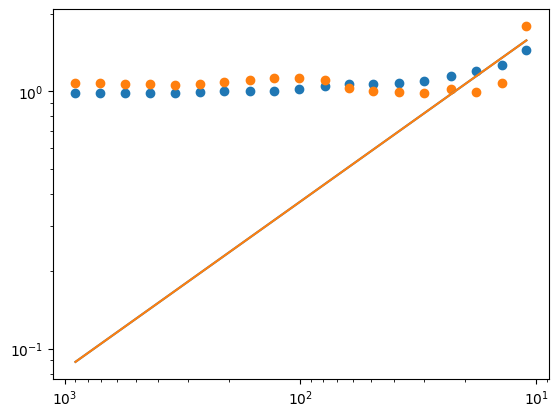

In [11]:
plt.scatter(measure_list[:-1], width_blk_list)
x = measure_list[:-1]

popt, pcov = curve_fit(power_law_scale, x[-5:], width_bdry_list[-5:])
plt.plot(x, power_law_scale(x, *popt))

plt.scatter(measure_list[:-1], width_bdry_list)

popt, pcov = curve_fit(power_law_scale, x[-5:], width_bdry_list[-5:])
plt.plot(x, power_law_scale(x, *popt))

plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
print(popt)

In [6]:
L = 50
fixed_length_slice = log_file[log_file['L']==L]
ts_list = fixed_length_slice['ts'].tolist()

w_vals = fixed_length_slice['w_blk'].tolist()
largest_clust_size = []
var_lcs = [] 
c_list = []
c_dict = {50:'red', 40:'blue', 60:'green', 80:'cyan', 30:'orange', 70:'olive'}

for index, ts in enumerate(ts_list):

    with open("IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    clust_dict_list, reverse_dict_list = [], []

    for core_pair in clust_list_final:
        clust_list_temp = core_pair[0] 
        reverse_list_temp = core_pair[1]
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])
    
    largest_clust_size.append(largest_clust_list.mean()/L**2)
    var_lcs.append(largest_clust_list.std()/L**2)
    c_list.append(c_dict[L])

Text(0.5, 1.0, 'Largest Spin Cluster and Variance in Size')

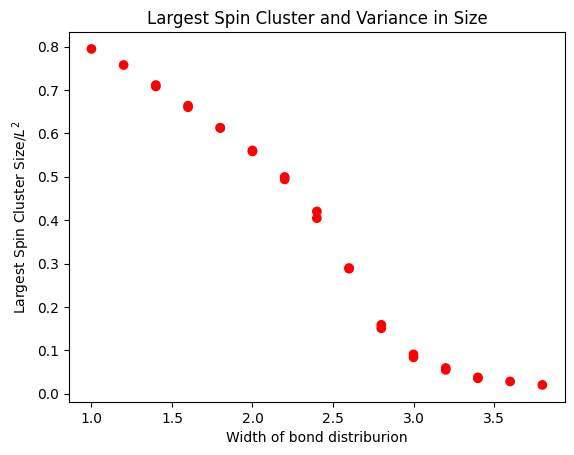

In [7]:
#plt.errorbar(w_vals, largest_clust_size, yerr=var_lcs, marker='o', linestyle='')
plt.scatter(w_vals, largest_clust_size, c=c_list)
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster and Variance in Size")

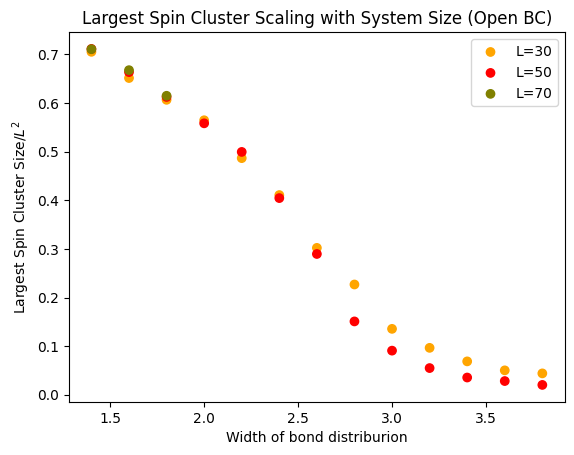

In [8]:
for L in [30, 50, 70]:
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['n_runs']==60)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w_blk'].tolist()
    largest_clust_size = []
    var_lcs = [] 
    c_list = []
    

    for index, ts in enumerate(ts_list):

        with open("IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []

        for core_pair in clust_list_final:
            clust_list_temp = core_pair[0]
            reverse_list_temp = core_pair[1]
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])

        largest_clust_size.append(largest_clust_list.mean()/L**2)
        var_lcs.append(largest_clust_list.std()/L**2)
        c_list.append(c_dict[L])

    plt.scatter(w_vals, largest_clust_size, c=c_list, label='L='+str(L))
    
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster Scaling with System Size (Open BC)")
plt.legend()

In [9]:
def check_percolation(clust_dict, L):
    end_point = L-1
    for y1 in range(L):
        for y2 in range(L):
            start_ind = index_map(0, y1, L)
            end_index = index_map(end_point, y2, L)
            if (clust_dict[start_ind] == clust_dict[end_index]): 
                return True
    return False
        

Text(0.5, 1.0, 'Percolation Transition')

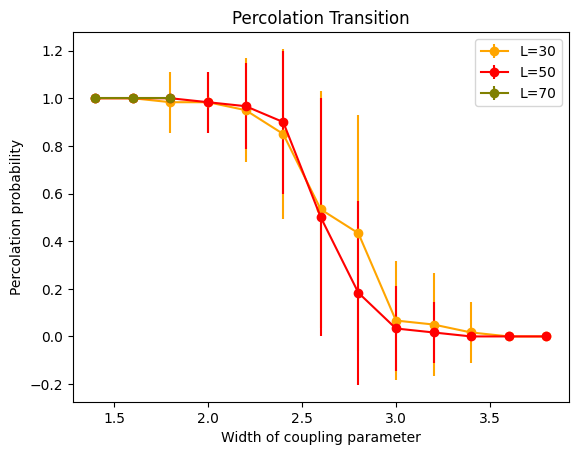

In [10]:
for L in [30, 50, 70]:
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['n_runs']==60)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w_blk'].tolist()

    p_perc_clust = []
    p_perc_clust_err = []
    c_list = []
    #color_dict = {50:'blue', 60:'red', 40:'green'}

    for index, ts in enumerate(ts_list):

        with open("IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []
        perc_cluster = []

        for core_pair in clust_list_final:
            clust_list_temp = core_pair[0]
            reverse_list_temp = core_pair[1]
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        perc_prob_temp = np.array([check_percolation(clust, L) for clust in clust_dict_list])

        p_perc_clust.append(perc_prob_temp.mean())
        p_perc_clust_err.append(perc_prob_temp.std())
        c_list.append(c_dict[L])
   
    #plt.scatter(w_vals, p_perc_clust, c=c_list, label="L="+str(L))
    #plt.errorbar(w_vals, p_perc_clust, yerr=p_perc_clust_err, c=c_dict[L], label="L="+str(L))
    
    sorted_y = np.array([x for _,x in sorted(zip(w_vals,p_perc_clust))])
    sorted_y_err = np.array([x for _,x in sorted(zip(w_vals,p_perc_clust_err))])
    sorted_x = np.array(sorted(w_vals))
    plt.errorbar(sorted_x, sorted_y, c=c_dict[L], label="L="+str(L), marker='o', yerr=sorted_y_err)
    

plt.legend()
plt.ylabel("Percolation probability")
plt.xlabel("Width of coupling parameter")
plt.title("Percolation Transition")

In [11]:
def cluster_size_color(L):
    if L==1: return 'blue'
    elif L>1 and L<10: return 'green'
    elif L>10 and L<30: return 'orange'
    elif L>30: return 'red'
    else: return 'white'

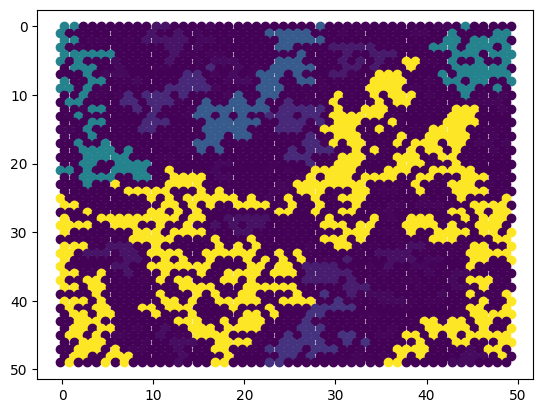

In [67]:
import matplotlib as mpl
import matplotlib.cm as cm

log_file = pd.read_csv("bdry_log_file.csv")
L = 50
fixed_log_slice = log_file[lambda df: (df['L'] == L)]
ts_list = log_file['ts'].tolist()
ts = str(ts_list[46])


with open("IsingB_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)


clust_dict = clust_list_final[1][0][0]
reverse_dict = clust_list_final[1][1][0]

norm = mpl.colors.Normalize(vmin=0, vmax=4*L)
cmap = 'viridis'#cm.hsv
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for x in range(L):
    for y in range(L):
        
        site_ind = index_map(x, y, L)
        """
        if clust_dict[site_ind] == site_ind: c='blue'
        else: 
            c = m.cmap(len(reverse_dict[clust_dict[site_ind]]))
        """
        c = m.cmap(len(reverse_dict[clust_dict[site_ind]]))
        plt.scatter(y+(0.25*(-1)**(x%2)), x, color=c)
        
        
plt.gca().invert_yaxis()

In [63]:
check_percolation(clust_dict, L)

False

In [49]:
fixed_log_slice

,L,steps,w_blk,w_bdry,w_mixed,n_runs,ts
11,50,2480,1.0,2.6,2.6,30,1678751622
12,50,2480,1.2,2.6,2.6,30,1678751971
13,50,2480,1.4,2.6,2.6,30,1678752324
14,50,2480,1.6,2.6,2.6,30,1678752668
15,50,2480,1.8,2.6,2.6,30,1678753020
16,50,2480,2.0,2.6,2.6,30,1678753375
17,50,2480,2.2,2.6,2.6,30,1678753735
18,50,2480,2.4,2.6,2.6,30,1678771457
19,50,2480,2.6,2.6,2.6,30,1678772088
20,50,2480,2.8,2.6,2.6,30,1678772729
